In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chisquare
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier as GBC

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

import warnings, math
warnings.simplefilter("ignore")

In [2]:
# hello world
data = pd.read_csv('../loan_data_2007_2014.csv', low_memory=False)
data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

   int_rate  installment grade sub_grade  ... total_bal_il il_util  \
0     10.65       162.87     B        B2  ...          NaN     NaN   
1     15.27        59.83     C        C4  ...          NaN     NaN   
2     15.96        84.33     C        C5  ...          NaN     NaN   
3     13.49       339.31     C        C1  ...          NaN     NaN   
4     12.69        67.79     B        B5  ...          NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN          NaN        NaN      NaN              NaN    NaN   
1         NaN          NaN        NaN      NaN              NaN    NaN   
2         NaN          NaN        NaN      NaN              NaN    NaN   
3         NaN          NaN        NaN      NaN              NaN    NaN   
4         NaN          NaN        NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 74 columns]

In [3]:
# preprocess the target column
''' 
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
'''

# following features will be labeled `1` to indicate "bad" loans
data['loan_status'] = data['loan_status'].replace(['Charged Off', 'Late (31-120 days)', 'Default',
                                                  'Does not meet the credit policy. Status:Charged Off'], 1)
# following features will be labeled `0` to indicate "good" loans
data['loan_status'] = data['loan_status'].replace(['Current', 'Fully Paid', 'In Grace Period', 'Late (16-30 days)',
                                                  'Does not meet the credit policy. Status:Fully Paid'], 0)

In [4]:
# split into train/test with ratio 7:3
TEST = data.sample(frac=0.3, axis=0)
data = data.drop(index=TEST.index, axis=0)

In [5]:
def calculate_woe(df, feature, y):
    ''' calculates WoE and IV for each feature '''
    df = pd.concat([df[feature], y], axis=1)
    target = df.columns.values[1]
    
    # calculate number of occurences of the given bin (support)
    support = df.groupby(feature, as_index=False)[target].count()
    # calculate the proportion of positive occurences 
    n_pos = df.groupby(feature, as_index = False)[target].mean()
    # get dataframe of (binned_feature, support, n_pos)
    df = pd.concat([support, n_pos], axis=1).iloc[:, [0, 1, 3]]
    df.columns = [feature, 'support', 'pos%']
    df['pos%'] = df['pos%'].apply(lambda x: 1-x)
    # count of positive/negative occurences
    positive = df['pos%'] * df['support']
    negative = (1 - df['pos%']) * df['support']
    # calculate what percentage of total positives/negatives given feature bin has
    pos = positive / positive.sum(); neg = negative / negative.sum()
    # finally calculate WoE and sort dataframe by WoE for plotting
    df['WoE'] = np.log(pos / neg)
    df = df.sort_values([feature]).reset_index(drop=True)
    # calculate IV using WoE
    df['IV'] = abs(((pos - neg) * df['WoE']).sum())
    return df

def plot_woe(df):
    ''' plots support, WoE and IV of each feature '''
    plt.figure(figsize=(10, 5))
    plt.plot(df.iloc[:, 0].astype(str), df['WoE'], marker = 'o', color='black')
    plt.xlabel(df.columns[0])
    plt.ylabel('WoE')

## Data Preprocessing

In [6]:
X_woe = pd.DataFrame()

### loan_amnt

loan_amnt  support      pos%       WoE        IV
0   (499.999, 8000.0]    87743  0.896026  0.053888  0.001684
1   (8000.0, 12000.0]    76014  0.891494  0.006150  0.001684
2  (12000.0, 20000.0]    94164  0.890330 -0.005827  0.001684
3  (20000.0, 35000.0]    68478  0.884445 -0.064730  0.001684

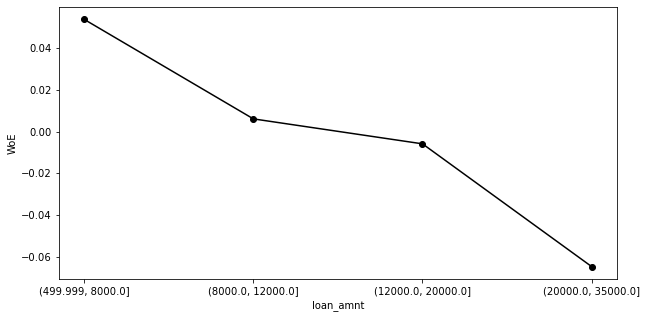

In [7]:
X_woe['loan_amnt'] = pd.qcut(data['loan_amnt'], 4)
df_temp = calculate_woe(X_woe, 'loan_amnt', data['loan_status'])
plot_woe(df_temp)
df_temp

### funded_amnt

funded_amnt  support      pos%       WoE       IV
0   (499.999, 8000.0]    87920  0.895871  0.052229  0.00148
1   (8000.0, 12000.0]    76133  0.891282  0.003967  0.00148
2  (12000.0, 20000.0]    94228  0.890181 -0.007346  0.00148
3  (20000.0, 35000.0]    68118  0.885038 -0.058914  0.00148

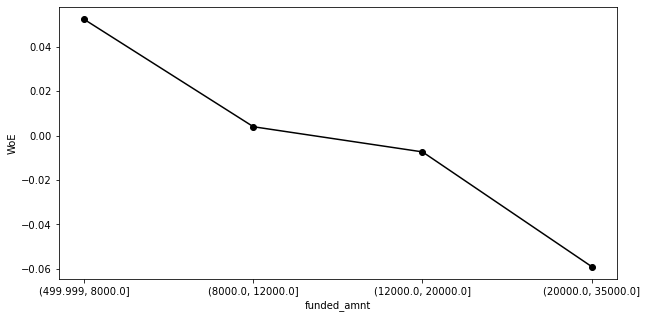

In [8]:
X_woe['funded_amnt'] = pd.qcut(data['funded_amnt'], 4)
df_temp = calculate_woe(X_woe, 'funded_amnt', data['loan_status'])
plot_woe(df_temp)
df_temp

### funded_amnt_inv

funded_amnt_inv  support      pos%       WoE        IV
0      (-35.0, 11666.667]   145757  0.891058  0.001658  0.000239
1  (11666.667, 23333.333]   128146  0.892061  0.012024  0.000239
2    (23333.333, 35000.0]    52496  0.887610 -0.033378  0.000239

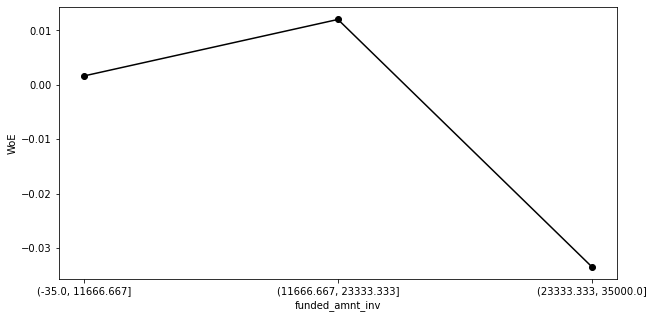

In [9]:
X_woe['funded_amnt_inv'] = pd.cut(data['funded_amnt_inv'], 3)
df_temp = calculate_woe(X_woe, 'funded_amnt_inv', data['loan_status'])
plot_woe(df_temp)
df_temp

### term

In [10]:
data['term'].value_counts()

 36 months    236600
 60 months     89799
Name: term, dtype: int64

term  support      pos%       WoE        IV
0   36 months   236600  0.903090  0.132095  0.038816
1   60 months    89799  0.858773 -0.294800  0.038816

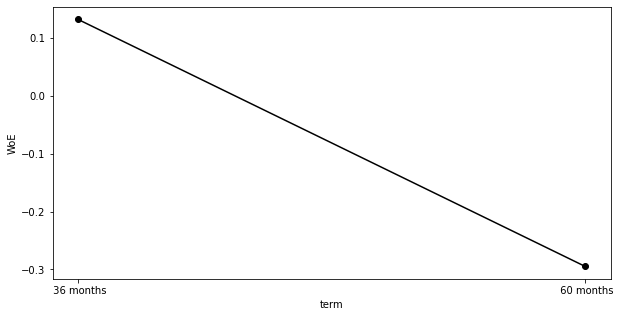

In [11]:
df_temp = calculate_woe(data, 'term', data['loan_status'])
plot_woe(df_temp)
df_temp

### int_rate

int_rate  support      pos%       WoE        IV
0   (5.399, 12.3]   120535  0.943195  0.709707  0.242939
1   (12.3, 19.18]   167686  0.875726 -0.147375  0.242939
2  (19.18, 26.06]    38178  0.792420 -0.760367  0.242939

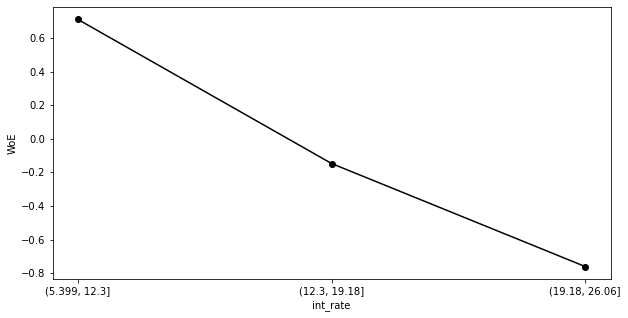

In [12]:
X_woe['int_rate'] = pd.cut(data['int_rate'], 3)
df_temp = calculate_woe(X_woe, 'int_rate', data['loan_status'])
plot_woe(df_temp)
df_temp

### installment

installment  support      pos%       WoE        IV
0   (15.669, 300.54]   108801  0.896058  0.054232  0.001964
1   (300.54, 495.81]   108801  0.891122  0.002317  0.001964
2  (495.81, 1409.99]   108797  0.885512 -0.054248  0.001964

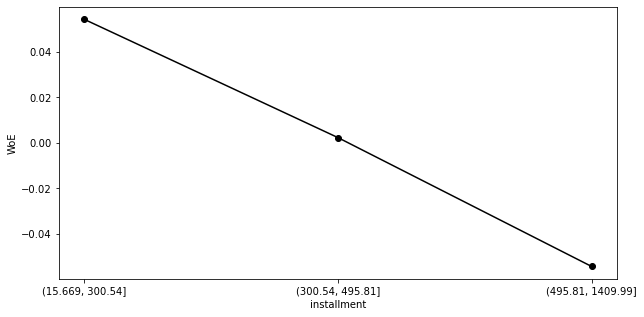

In [13]:
X_woe['installment'] = pd.qcut(data['installment'], 3)
df_temp = calculate_woe(X_woe, 'installment', data['loan_status'])
plot_woe(df_temp)
df_temp

### grade

grade  support      pos%       WoE        IV
0     A    52497  0.961941  1.129867  0.295028
1     B    95738  0.921525  0.363316  0.295028
2     C    87825  0.885705 -0.052343  0.295028
3     D    53780  0.845407 -0.400916  0.295028
4     E    25015  0.804757 -0.683644  0.295028
5     F     9234  0.759909 -0.947759  0.295028
6     G     2310  0.719913 -1.155908  0.295028

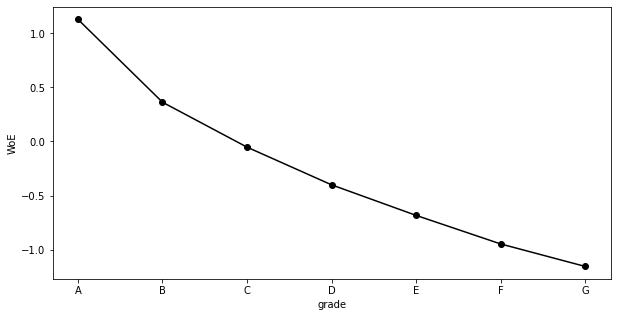

In [14]:
df_temp = calculate_woe(data, 'grade', data['loan_status'])
plot_woe(df_temp)
df_temp

### sub_grade

sub_grade  support      pos%       WoE        IV
0         A1     7478  0.980744  1.830523  0.318831
1         A2     7634  0.973539  1.505343  0.318831
2         A3     8800  0.965341  1.226981  0.318831
3         A4    13364  0.956076  0.980437  0.318831
4         A5    15221  0.950069  0.845952  0.318831
5         B1    15905  0.939956  0.650815  0.318831
6         B2    18637  0.931158  0.504682  0.318831
7         B3    22174  0.920989  0.355915  0.318831
8         B4    21279  0.912684  0.246914  0.318831
9         B5    17743  0.906160  0.167687  0.318831
10        C1    18912  0.894934  0.042226  0.318831
11        C2    18787  0.892798  0.019708  0.318831
12        C3    17666  0.885486 -0.054498  0.318831
13        C4    16898  0.880223 -0.105401  0.318831
14        C5    15562  0.872124 -0.180066  0.318831
15        D1    13335  0.858793 -0.294642  0.318831
16        D2    12070  0.848053 -0.380528  0.318831
17        D3    10397  0.847360 -0.385898  0.318831
18        D4     9840  0.834654 -0.480959  0.318831
19        D5     8138  0.830057 -0.513912  0.318831
20        E1     6345  0.826005 -0.542368  0.318831
21        E2     6047  0.807508 -0.666042  0.318831
22        E3     4937  0.807170 -0.668212  0.318831
23        E4     4179  0.789184 -0.779926  0.318831
24        E5     3507  0.776732 -0.853216  0.318831
25        F1     2710  0.781919 -0.823056  0.318831
26        F2     2119  0.768759 -0.898624  0.318831
27        F3     1905  0.755381 -0.972422  0.318831
28        F4     1442  0.744799 -1.028878  0.318831
29        F5     1058  0.714556 -1.182326  0.318831
30        G1      775  0.704516 -1.231043  0.318831
31        G2      577  0.712305 -1.193334  0.318831
32        G3      400  0.727500 -1.117965  0.318831
33        G4      294  0.768707 -0.898913  0.318831
34        G5      264  0.715909 -1.175681  0.318831

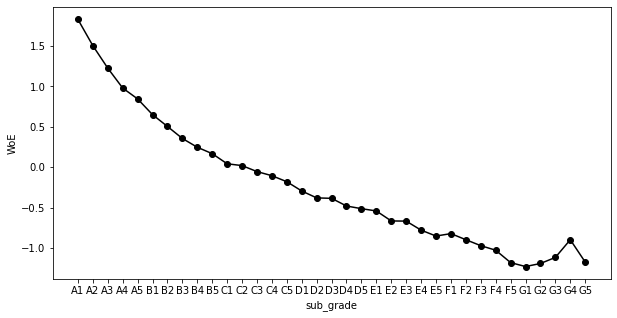

In [15]:
df_temp = calculate_woe(data, 'sub_grade', data['loan_status'])
plot_woe(df_temp)
df_temp

sub_grade  support      pos%       WoE        IV
0  (-0.001, 18.0]    77004  0.815867 -0.611349  0.284438
1    (18.0, 22.0]    63461  0.875199 -0.152210  0.284438
2    (22.0, 25.0]    55442  0.897803  0.073110  0.284438
3    (25.0, 29.0]    77995  0.925021  0.412666  0.284438
4    (29.0, 34.0]    52497  0.961941  1.129867  0.284438

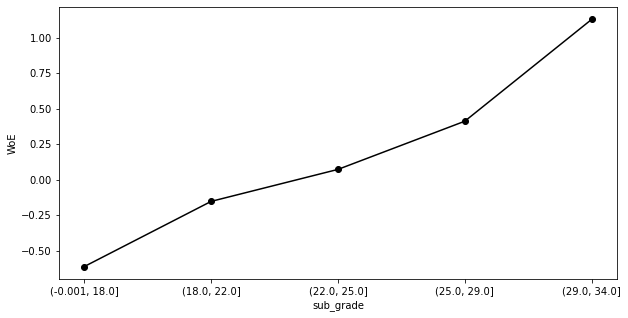

In [16]:
# since grades are ordinal data (we can compare them), its best to use a label encoder here. Otherwise we have too many features
grades = list(data['sub_grade'].unique())
grades.sort(reverse=True) # sorts grades as [G5, G4, ... A2, A1]
grades_map = dict(zip(grades, list(range(len(grades))))) # get dict of corresponding indices
data['sub_grade'] = data['sub_grade'].apply(lambda x: grades_map[x])
# plot the results
X_woe['sub_grade'] = pd.qcut(data['sub_grade'], 5)
df_temp = calculate_woe(X_woe, 'sub_grade', data['loan_status'])
plot_woe(df_temp)
df_temp

We have effectively reduced number of features from 35 to 10 while also increasing the IV

### emp_length

In [17]:
# lots of nan, best strategy would be to make it a separate category
data['emp_length'] = data['emp_length'].fillna('NaN')

emp_length  support      pos%       WoE        IV
0      1 year    20777  0.890311 -0.006014  0.006456
1   10+ years   105069  0.899942  0.096640  0.006456
2     2 years    28994  0.890046 -0.008727  0.006456
3     3 years    25367  0.890488 -0.004208  0.006456
4     4 years    19514  0.889054 -0.018825  0.006456
5     5 years    21514  0.885330 -0.056033  0.006456
6     6 years    18290  0.882887 -0.079884  0.006456
7     7 years    18453  0.889882 -0.010399  0.006456
8     8 years    15706  0.891443  0.005624  0.006456
9     9 years    12502  0.888898 -0.020408  0.006456
10   < 1 year    25475  0.881845 -0.089921  0.006456
11        NaN    14738  0.868164 -0.215119  0.006456

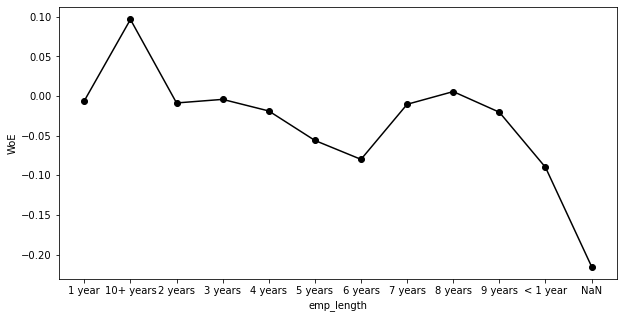

In [18]:
df_temp = calculate_woe(data, 'emp_length', data['loan_status'])
plot_woe(df_temp)
df_temp

In [19]:
# again, we have an ordinal feature, best to label encode it
emp_len = ['NaN', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
           '6 years', '7 years', '8 years', '9 years', '10+ years']
emp_len_map = dict(zip(emp_len, range(len(emp_len))))
data['emp_length'] = data['emp_length'].apply(lambda x: emp_len_map[x])

emp_length  support      pos%       WoE        IV
0  (-0.011, 2.75]    60990  0.881423 -0.093963  0.004362
1     (2.75, 5.5]    73875  0.889936 -0.009855  0.004362
2     (5.5, 8.25]    58257  0.886005 -0.049371  0.004362
3    (8.25, 11.0]   133277  0.897904  0.074214  0.004362

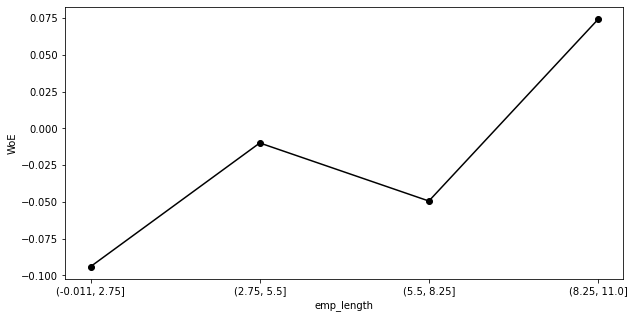

In [20]:
# plot the results
X_woe['emp_length'] = pd.cut(data['emp_length'], 4)
df_temp = calculate_woe(X_woe, 'emp_length', data['loan_status'])
plot_woe(df_temp)
df_temp

### home_ownership

home_ownership  support      pos%       WoE        IV
0       MORTGAGE   165330  0.904119  0.143914  0.021326
1            OWN    29288  0.892106  0.012496  0.021326
2           RENT   131781  0.874041 -0.162769  0.021326

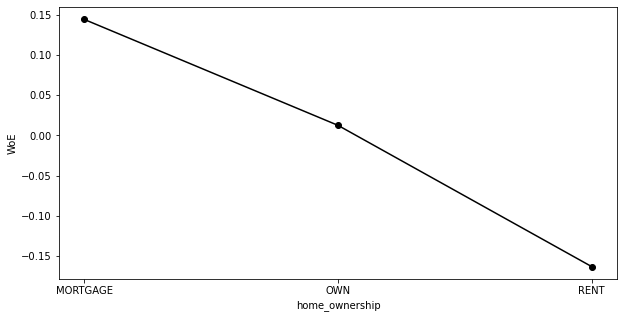

In [21]:
# features ANY/NONE/OTHER contain too few samples, therefore we aggregate them with mode - MORTGAGE
data['home_ownership'] = data['home_ownership'].replace(['ANY', 'NONE', 'OTHER'], 'MORTGAGE')
df_temp = calculate_woe(data, 'home_ownership', data['loan_status'])
plot_woe(df_temp)
df_temp

### annual_inc

In [22]:
data['annual_inc'] = data['annual_inc'].fillna(data['annual_inc'].median())

annual_inc  support      pos%       WoE        IV
0   (1895.999, 50000.0]   110335  0.865664 -0.236790  0.046739
1    (50000.0, 78000.0]   107728  0.890948  0.000517  0.046739
2  (78000.0, 6100000.0]   108336  0.916547  0.296386  0.046739

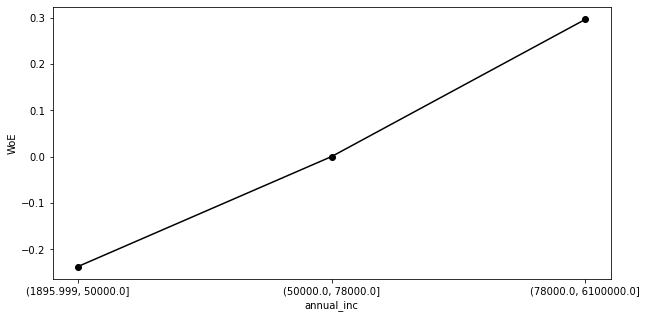

In [23]:
X_woe['annual_inc'] = pd.qcut(data['annual_inc'], 3)
df_temp = calculate_woe(X_woe, 'annual_inc', data['loan_status'])
plot_woe(df_temp)
df_temp

### verification_status

verification_status  support      pos%       WoE        IV
0        Not Verified   103676  0.905947  0.165187  0.021375
1     Source Verified   105241  0.896656  0.060672  0.021375
2            Verified   117482  0.872457 -0.177080  0.021375

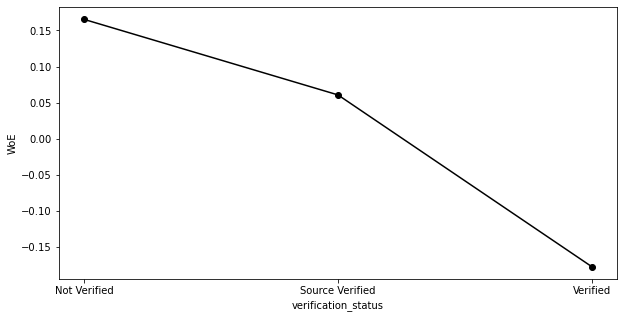

In [24]:
df_temp = calculate_woe(data, 'verification_status', data['loan_status'])
plot_woe(df_temp)
df_temp

### issue_d

In [25]:
# based on domain knowledge, its best to omit this feature, banks to not give any preference to any specific issue dates
print(data['issue_d'].describe())
print(data['issue_d'].isnull().sum())

count     326399
unique        91
top       Oct-14
freq       27172
Name: issue_d, dtype: object
0


### pymnt_plan

In [26]:
# omit this feature, features with value `y` are encountered very rarely
print(data['pymnt_plan'].value_counts())
print(data['pymnt_plan'].isnull().sum())

n    326391
y         8
Name: pymnt_plan, dtype: int64
0


### purpose

In [27]:
data['purpose'].value_counts()

debt_consolidation    192140
credit_card            72796
home_improvement       18567
other                  16581
major_purchase          6894
small_business          4891
car                     3785
medical                 3184
moving                  2047
vacation                1781
wedding                 1614
house                   1592
educational              285
renewable_energy         242
Name: purpose, dtype: int64

purpose  support      pos%       WoE        IV
0         credit_card    72796  0.913786  0.260830  0.023873
1  debt_consolidation   192140  0.887218 -0.037309  0.023873
2    home_improvement    18567  0.900199  0.099501  0.023873
3               other    42896  0.864510 -0.246679  0.023873

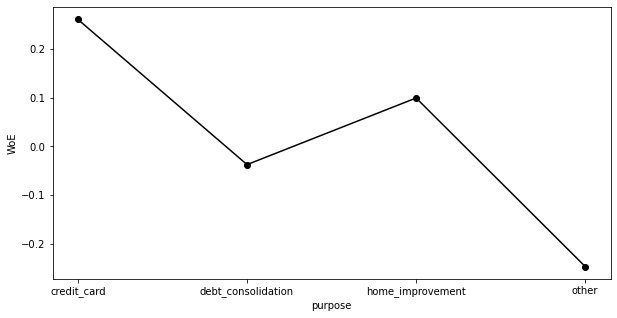

In [28]:
data['purpose'] = data['purpose'].apply(lambda x: x if x in ['debt_consolidation', 'credit_card', 'home_improvement'] else 'other')
df_temp = calculate_woe(data, 'purpose', data['loan_status'])
plot_woe(df_temp)
df_temp

purpose  support      pos%       WoE        IV
0         credit_card    72796  0.913786  0.260830  0.023873
1  debt_consolidation   192140  0.887218 -0.037309  0.023873
2    home_improvement    18567  0.900199  0.099501  0.023873
3               other    42896  0.864510 -0.246679  0.023873

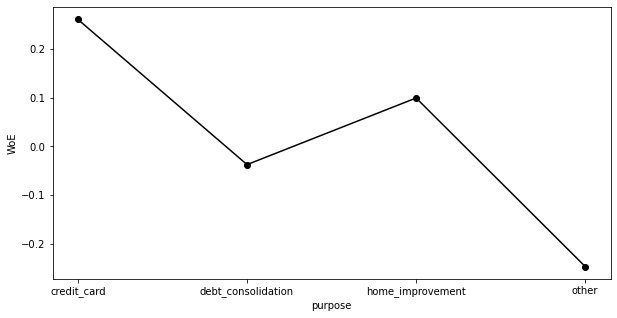

In [29]:
data['purpose'] = data['purpose'].replace(['educational', 'renewable_energy', 'small_business', 'moving', 'house', 'medical',
                                      'wedding', 'vacation', 'major_purchase', 'car'], 'other')
df_temp = calculate_woe(data, 'purpose', data['loan_status'])
plot_woe(df_temp)
df_temp

-----------------------------------------------------------------------

# dti

dti  support      pos%       WoE        IV
0  (-0.001, 11.35]    81627  0.909638  0.209280  0.023607
1   (11.35, 16.87]    81621  0.899560  0.092407  0.023607
2   (16.87, 22.78]    81623  0.883844 -0.070593  0.023607
3   (22.78, 39.99]    81528  0.870523 -0.194349  0.023607

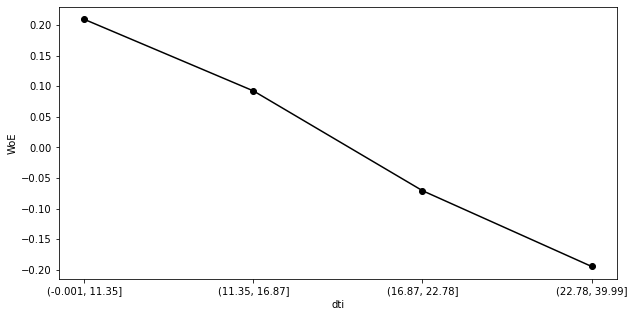

In [30]:
X_woe['dti'] = pd.qcut(data['dti'], 4)
df_temp = calculate_woe(X_woe, 'dti', data['loan_status'])
plot_woe(df_temp)
df_temp

# delinq_2yrs

In [31]:
data['delinq_2yrs'].describe()

count    326379.000000
mean          0.283787
std           0.797643
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: delinq_2yrs, dtype: float64

In [32]:
#as there are only 29 null values we can replace them with the median of the data
data['delinq_2yrs'] = data['delinq_2yrs'].fillna(data['delinq_2yrs'].median())

In [33]:
data['delinq_2yrs'] = data['delinq_2yrs'].apply(lambda x: 2 if x>=2 else x)

delinq_2yrs  support      pos%       WoE        IV
0          0.0   268260  0.890897 -0.000005  0.000134
1          1.0    39257  0.892758  0.019287  0.000134
2          2.0    18882  0.887035 -0.039131  0.000134

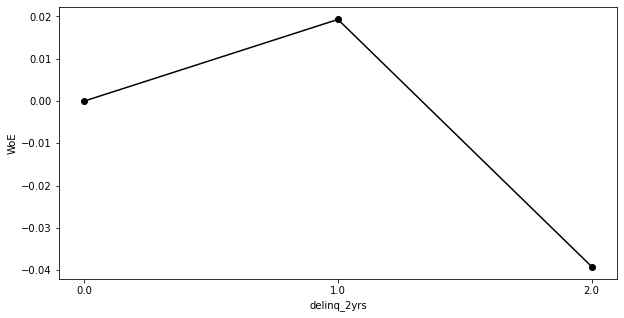

In [34]:
df_temp = calculate_woe(data, 'delinq_2yrs', data['loan_status'])
plot_woe(df_temp)
df_temp

# earliest_cr_line

In [35]:
# Date features in this dataset have inconsistent formatting, therefore they cannot be processed properly

# inq_last_6mths

In [36]:
data['inq_last_6mths'] = data['inq_last_6mths'].apply(lambda x: 2 if x>1 else x)

In [37]:
# as there are only 29 null values we can replace them with the median of the data
data['inq_last_6mths'] = data['inq_last_6mths'].fillna(data['inq_last_6mths'].median())

inq_last_6mths  support      pos%       WoE        IV
0  (-0.002, 0.667]   169242  0.908947  0.200905  0.046292
1   (0.667, 1.333]    90901  0.884149 -0.067622  0.046292
2     (1.333, 2.0]    66256  0.854051 -0.333207  0.046292

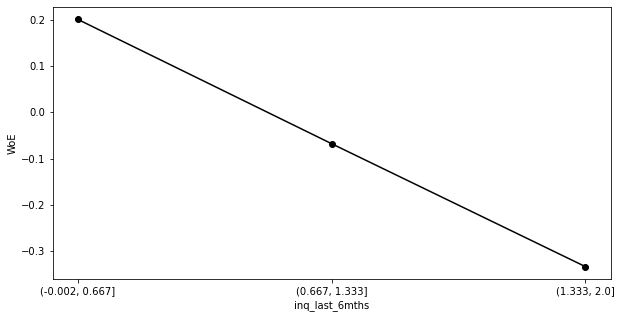

In [38]:
X_woe['inq_last_6mths'] = pd.cut(data['inq_last_6mths'], 3)
df_temp = calculate_woe(X_woe, 'inq_last_6mths', data['loan_status'])
plot_woe(df_temp)
df_temp

# mths_since_last_delinq

In [39]:
# there are lots of nan, best thing to do would be to make it a separate category
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].replace(['NaN'],0)

In [40]:
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].apply(lambda x: 28 if x>0 else x)

In [41]:
#as IV value is less and also more than 50 percent of data is not given in the data set
#we can ignore this 'mths_since_last_delinq' column

# mths_since_last_record

In [42]:
data['mths_since_last_record'].isnull().sum()

282393

In [43]:
# nearly 90 percent of data is Nan. so we can safely ignore this column

# open_acc

In [44]:
#as there are only 29 null values we can replace them with the median of the data. also mode is almost same as mean here.
data['open_acc'] = data['open_acc'].fillna(data['open_acc'].median())

open_acc  support      pos%       WoE       IV
0  (-0.001, 10.0]   166983  0.889857 -0.010658  0.00012
1    (10.0, 75.0]   159416  0.891987  0.011260  0.00012

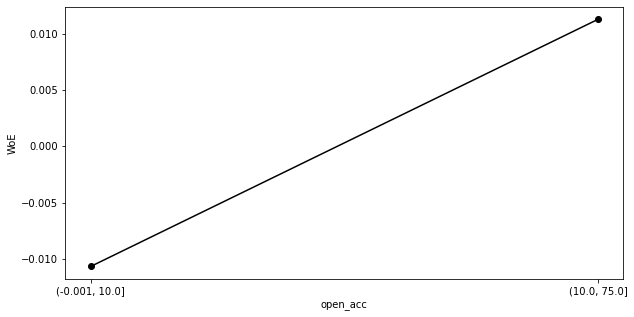

In [45]:
X_woe['open_acc'] = pd.qcut(data['open_acc'], 2)
df_temp = calculate_woe(X_woe, 'open_acc', data['loan_status'])
plot_woe(df_temp)
df_temp

In [46]:
#IV value is very low. so we can ignore this column

# pub_rec

In [47]:
data['pub_rec'] = data['pub_rec'].apply(lambda x: 1 if x>0 else x)

In [48]:
#as there are only 29 null values we can replace them with the median of the data
data['pub_rec'] = data['pub_rec'].fillna(data['pub_rec'].median())

pub_rec  support      pos%       WoE        IV
0      0.0   283292  0.890071 -0.008473  0.000484
1      1.0    43107  0.896328  0.057132  0.000484

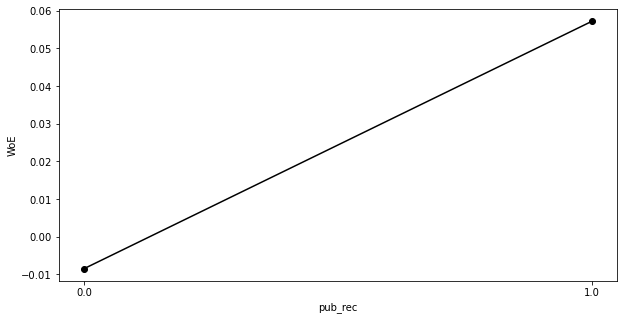

In [49]:
df_temp = calculate_woe(data, 'pub_rec', data['loan_status'])
plot_woe(df_temp)
df_temp

### revol_bal

revol_bal  support      pos%       WoE        IV
0      (-0.001, 5435.0]    65282  0.886600 -0.043471  0.004976
1      (5435.0, 9445.0]    65282  0.887029 -0.039198  0.004976
2     (9445.0, 14520.0]    65277  0.886882 -0.040659  0.004976
3    (14520.0, 23185.0]    65283  0.889849 -0.010742  0.004976
4  (23185.0, 2568995.0]    65275  0.904129  0.144025  0.004976

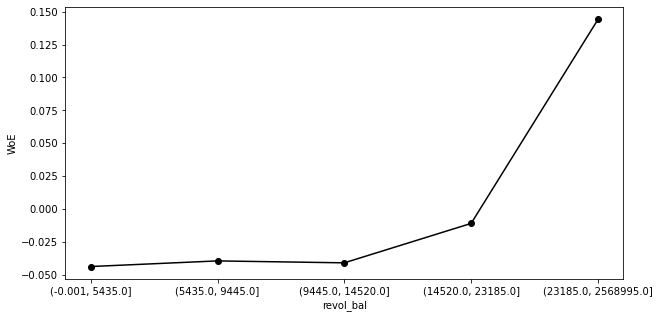

In [50]:
X_woe['revol_bal'] = pd.qcut(data['revol_bal'], 5)
df_temp = calculate_woe(X_woe, 'revol_bal', data['loan_status'])
plot_woe(df_temp)
df_temp

### revol_util

In [51]:
data['revol_util'] = data['revol_util'].fillna(data['revol_util'].median())

revol_util  support      pos%       WoE        IV
0  (-0.001, 39.2]    81690  0.911213  0.228598  0.024848
1    (39.2, 57.5]    81652  0.897749  0.072520  0.024848
2    (57.5, 74.7]    81526  0.884417 -0.064998  0.024848
3   (74.7, 177.7]    81531  0.870160 -0.197567  0.024848

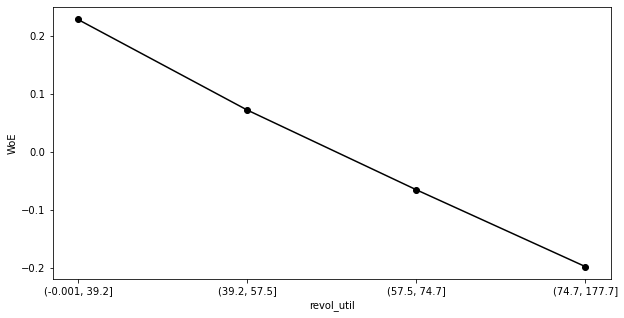

In [52]:
X_woe['revol_util'] = pd.qcut(data['revol_util'], 4)
df_temp = calculate_woe(X_woe, 'revol_util', data['loan_status'])
plot_woe(df_temp)
df_temp

### total_acc

total_acc  support      pos%       WoE        IV
0  (0.999, 17.0]    92632  0.879221 -0.114892  0.006325
1   (17.0, 23.0]    70806  0.891704  0.008301  0.006325
2   (23.0, 32.0]    86679  0.895246  0.045515  0.006325
3  (32.0, 156.0]    76262  0.899399  0.090604  0.006325

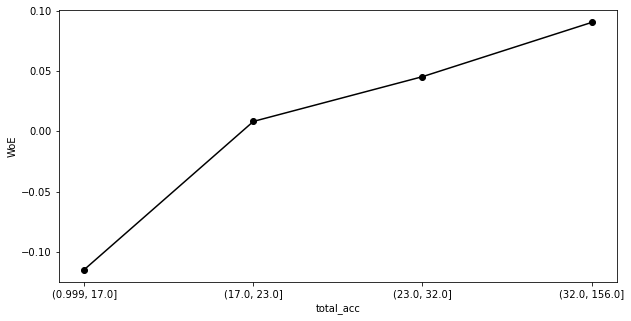

In [53]:
X_woe['total_acc'] = pd.qcut(data['total_acc'], 4)
df_temp = calculate_woe(X_woe, 'total_acc', data['loan_status'])
plot_woe(df_temp)
df_temp
# feature can be discarded as IV is Too Low 

### initial_list_status

initial_list_status  support      pos%       WoE        IV
0                   f   212120  0.880082 -0.106733  0.024033
1                   w   114279  0.910972  0.225625  0.024033

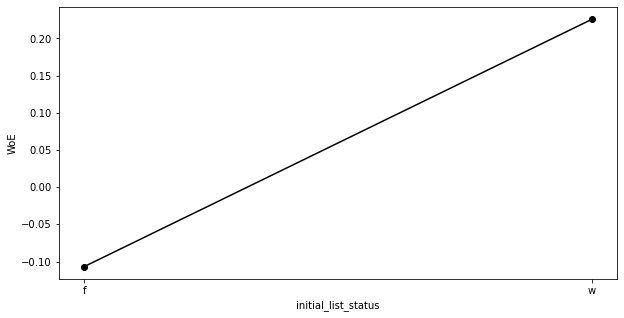

In [54]:
df_temp = calculate_woe(data, 'initial_list_status', data['loan_status'])
plot_woe(df_temp)
df_temp

### out_prncp

out_prncp  support      pos%       WoE        IV
0    (-0.001, 453.02]   163200  0.814853 -0.618083  0.740902
1  (453.02, 32160.38]   163199  0.966942  1.275941  0.740902

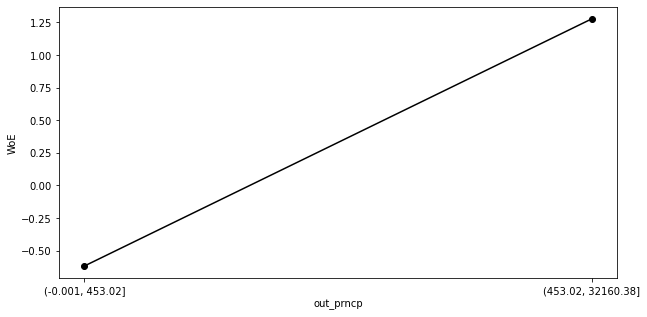

In [55]:
X_woe['out_prncp'] = pd.qcut(data['out_prncp'], 2, duplicates='drop')
df_temp = calculate_woe(X_woe, 'out_prncp', data['loan_status'])
plot_woe(df_temp)
df_temp

### out_prncp_inv

In [56]:
# is inverse of `out_prncp` feature, redundant

### total_pymnt

total_pymnt  support      pos%       WoE        IV
0     (-0.001, 5556.116]    81600  0.776213 -0.856206  0.523952
1    (5556.116, 9418.89]    81600  0.892843  0.020177  0.523952
2   (9418.89, 15314.035]    81599  0.930980  0.501895  0.523952
3  (15314.035, 57777.58]    81600  0.963554  1.174855  0.523952

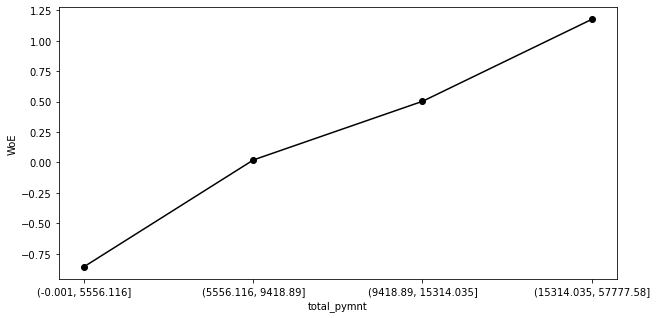

In [57]:
X_woe['total_pymnt'] = pd.qcut(data['total_pymnt'], 4, duplicates='drop')
df_temp = calculate_woe(X_woe, 'total_pymnt', data['loan_status'])
plot_woe(df_temp)
df_temp

## total_rec_prncp

total_rec_prncp  support      pos%       WoE        IV
0   (-0.001, 3710.955]    81600  0.724191 -1.134592  1.101699
1  (3710.955, 6822.26]    81600  0.903419  0.135866  1.101699
2   (6822.26, 12000.0]    86668  0.954008  0.932274  1.101699
3  (12000.0, 35000.02]    76531  0.983824  2.007950  1.101699

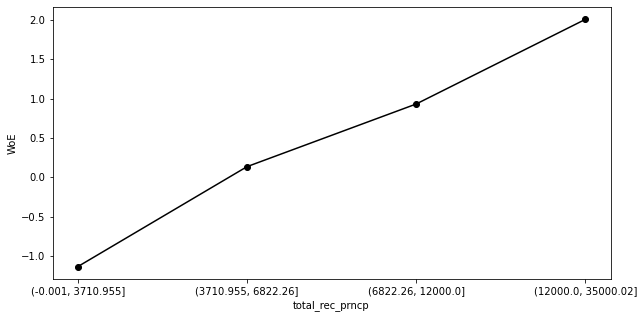

In [58]:
X_woe['total_rec_prncp'] = pd.qcut(data['total_rec_prncp'], 4)
df_temp = calculate_woe(X_woe, 'total_rec_prncp', data['loan_status'])
plot_woe(df_temp)
df_temp

## total_rec_int

total_rec_int  support      pos%       WoE        IV
0    (-0.001, 1817.92]   163205  0.881517 -0.093064  0.009334
1  (1817.92, 23450.38]   163194  0.900278  0.100380  0.009334

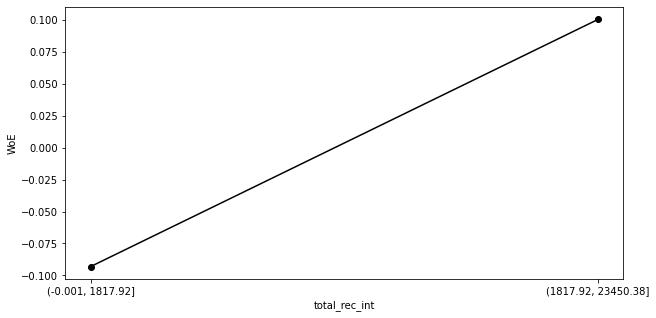

In [59]:
X_woe['total_rec_int'] = pd.qcut(data['total_rec_int'], 2)
df_temp = calculate_woe(X_woe, 'total_rec_int', data['loan_status'])
plot_woe(df_temp)
df_temp

## total_rec_late_fee

total_rec_late_fee  support      pos%       WoE        IV
0   (-0.359, 179.34]   326385  0.890914  0.000173  0.000362
1   (179.34, 358.68]       14  0.500000 -2.099940  0.000362

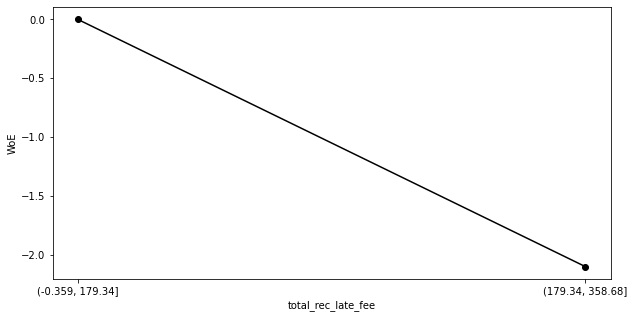

In [60]:
X_woe['total_rec_late_fee'] = pd.cut(data['total_rec_late_fee'], 2, duplicates='drop')
df_temp = calculate_woe(X_woe, 'total_rec_late_fee', data['loan_status'])
plot_woe(df_temp)
df_temp

## recoveries

recoveries  support      pos%       WoE   IV
0     (-33.52, 11173.423]   326331  0.891083  0.001911  inf
1  (11173.423, 22346.847]       59  0.000000      -inf  inf
2   (22346.847, 33520.27]        9  0.000000      -inf  inf

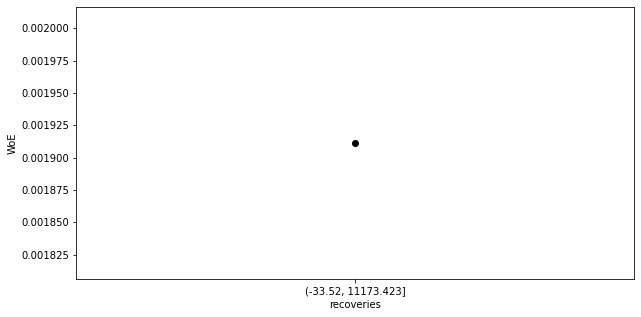

In [61]:
X_woe['recoveries'] = pd.cut(data['recoveries'], 3)
df_temp = calculate_woe(X_woe, 'recoveries', data['loan_status'])
plot_woe(df_temp)
df_temp
#IV values is NaN and almost all the values are 0's.

## collection_recovery_fee

collection_recovery_fee  support      pos%       WoE   IV
0      (-7.002, 3501.095]   326381  0.890946  0.000506  inf
1     (3501.095, 7002.19]       18  0.000000      -inf  inf

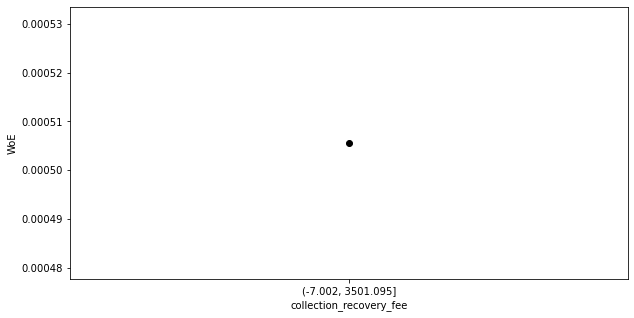

In [62]:
X_woe['collection_recovery_fee'] = pd.cut(data['collection_recovery_fee'], 2)
df_temp = calculate_woe(X_woe, 'collection_recovery_fee', data['loan_status'])
plot_woe(df_temp)
df_temp

## last_pymnt_amnt

last_pymnt_amnt  support      pos%       WoE        IV
0    (-0.001, 545.99]   163213  0.842384 -0.423867  0.265851
1  (545.99, 36004.61]   163186  0.939419  0.641337  0.265851

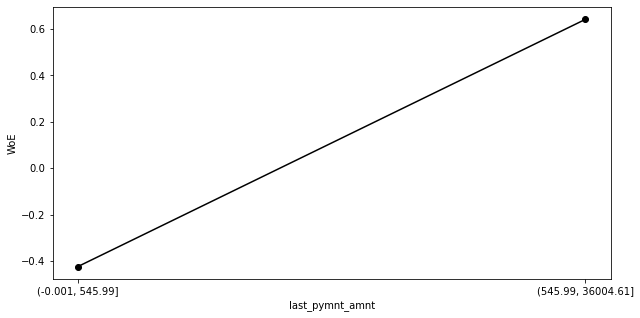

In [63]:
X_woe['last_pymnt_amnt'] = pd.qcut(data['last_pymnt_amnt'], 2)
df_temp = calculate_woe(X_woe, 'last_pymnt_amnt', data['loan_status'])
plot_woe(df_temp)
df_temp

collections_12_mths_ex_med  support      pos%       WoE   IV
0             (-0.02, 6.667]   326298  0.890916 -0.000007  inf
1            (6.667, 13.333]        0       NaN       NaN  inf
2             (13.333, 20.0]        2  1.000000       inf  inf

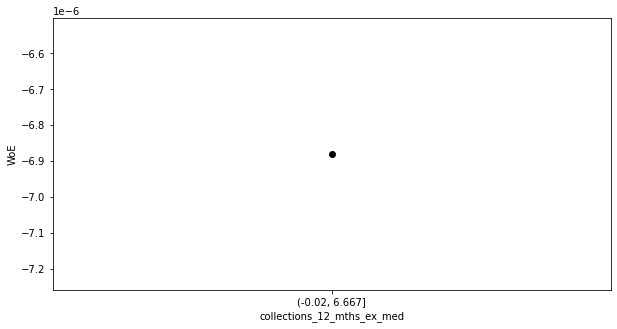

In [64]:
X_woe['collections_12_mths_ex_med'] = pd.cut(data['collections_12_mths_ex_med'], 3)
df_temp = calculate_woe(X_woe, 'collections_12_mths_ex_med', data['loan_status'])
plot_woe(df_temp)
df_temp
#IV values is negligible and almost all the values are 0's.

## Data transformation

In [65]:
def transform(df):
    ''' takes regular, unprocessed data as input and produces binary matrix representation '''
    out = pd.DataFrame()
    out['int_rate:(5.399, 12.3]'] = np.where(df['int_rate'] <= 12.3, 1, 0)
    out['int_rate:(12.3, 19.18]'] = np.where((df['int_rate'] > 12.3) & (df['int_rate'] <= 19.18), 1, 0)
    out['int_rate:(19.18, 26.06]'] = np.where(df['int_rate'] > 19.18, 1, 0)
    out['annual_inc:(1895.999, 50000.0]'] = np.where(df['annual_inc'] <= 50_000, 1, 0)
    out['annual_inc:(50000.0, 78000.0]'] = np.where((df['annual_inc'] > 50_000) & (df['annual_inc'] <= 78_000), 1, 0)
    out['annual_inc:(78000.0, 7500000.0]'] = np.where(df['annual_inc'] > 78_000, 1, 0)
    out['dti:(-0.001, 11.36]'] = np.where(df['dti'] <= 11.36, 1, 0)
    out['dti:(11.36, 16.87]'] = np.where((df['dti'] > 11.36) & (df['dti'] <= 16.87), 1, 0)
    out['dti:(16.87, 22.78]'] = np.where((df['dti'] > 16.87) & (df['dti'] <= 22.78), 1, 0)
    out['dti:(22.78, 39.99]'] = np.where(df['dti'] > 22.78, 1, 0)
    out['inq_last_6mths:(-0.002, 0.667]'] = np.where(df['inq_last_6mths'] <= 0.667, 1, 0)
    out['inq_last_6mths:(0.667, 1.333]'] = np.where((df['inq_last_6mths'] > 0.667) & (df['inq_last_6mths'] <= 1.333), 1, 0)
    out['inq_last_6mths:(1.333, 2.0]'] = np.where(df['inq_last_6mths'] > 1.333, 1, 0)
    out['revol_util:(-0.001, 39.2]'] = np.where(df['revol_util'] <= 39.2, 1, 0)
    out['revol_util:(39.2, 57.6]'] = np.where((df['revol_util'] > 39.2) & (df['revol_util'] <= 57.6), 1, 0)
    out['revol_util:(57.6, 74.7]'] = np.where((df['revol_util'] > 57.6) & (df['revol_util'] <= 74.7), 1, 0)
    out['revol_util:(74.7, 892.3]'] = np.where(df['revol_util'] > 74.7, 1, 0)
    out['out_prncp:(-0.001, 441.47]'] = np.where(df['out_prncp'] <= 441.47, 1, 0)
    out['out_prncp:(441.47, 32160.38]'] = np.where(df['out_prncp'] > 441.47, 1, 0)
    out['total_pymnt:(-0.001, 5552.125]'] = np.where(df['total_pymnt'] <= 5552.125, 1, 0)
    out['total_pymnt:(5552.125, 9419.251]'] = np.where((df['total_pymnt']>5552.125) & (df['total_pymnt']<=9419.251), 1, 0)
    out['total_pymnt:(9419.251, 15308.158]'] = np.where((df['total_pymnt']>9419.251) & (df['total_pymnt']<15308.158), 1, 0)
    out['total_pymnt:(15308.158, 57777.58]'] = np.where(df['total_pymnt'] > 15308.158, 1, 0)
    out['last_pymnt_amnt:(-0.001, 545.96]'] = np.where(df['last_pymnt_amnt']<=545.96, 1, 0)
    out['last_pymnt_amnt:(545.96, 36234.44]'] = np.where(df['last_pymnt_amnt']>545.96, 1, 0)
    out['term: 36 months'] = np.where(df['term'] == ' 36 months', 1, 0)
    out['term: 60 months'] = np.where(df['term'] == ' 60 months', 1, 0)
    out['grade:A'] = np.where(df['grade']=='A', 1, 0)
    out['grade:B'] = np.where(df['grade']=='B', 1, 0)
    out['grade:C'] = np.where(df['grade']=='C', 1, 0)
    out['grade:D'] = np.where(df['grade']=='D', 1, 0)
    out['grade:E'] = np.where(df['grade']=='E', 1, 0)
    out['grade:F'] = np.where(df['grade']=='F', 1, 0)
    out['grade:G'] = np.where(df['grade']=='G', 1, 0)
    out['verification_status:Not Verified'] = np.where(df['verification_status']=='Not Verified', 1, 0)
    out['verification_status:Source Verified'] = np.where(df['verification_status']=='Source Verified', 1, 0)
    out['verification_status:Verified'] = np.where(df['verification_status']=='Verified', 1, 0)
    df['purpose'] = df['purpose'].apply(lambda x: x if x in ['debt_consolidation', 'credit_card', 'home_improvement'] else 'other')
    out['purpose:credit_card'] = np.where(df['purpose']=='credit_card', 1, 0)
    out['purpose:debt_consolidation'] = np.where(df['purpose']=='debt_consolidation', 1, 0)
    out['purpose:home_improvement'] = np.where(df['purpose']=='home_improvement', 1, 0)
    out['purpose:other'] = np.where(df['purpose']=='other', 1, 0)
    out['home_ownership:MORTGAGE'] = np.where(df['home_ownership']=='MORTGAGE', 1, 0)
    out['home_ownership:OWN'] = np.where(df['home_ownership']=='OWN', 1, 0)
    out['home_ownership:RENT'] = np.where(df['home_ownership']=='RENT', 1, 0)
    out['initial_list_status:f'] = np.where(df['initial_list_status']=='f', 1, 0)
    out['initial_list_status:w'] = np.where(df['initial_list_status']=='w', 1, 0)
    return out

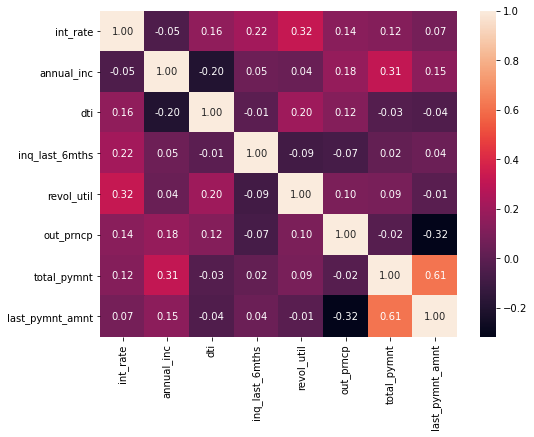

term : grade -> 0.0
term : verification_status -> 0.0
term : purpose -> 0.0
term : home_ownership -> 0.0
term : initial_list_status -> 0.0
grade : verification_status -> 0.0
grade : purpose -> 0.0
grade : home_ownership -> 0.0
grade : initial_list_status -> 7.665929301662164e-110
verification_status : purpose -> 0.0
verification_status : home_ownership -> 0.0
verification_status : initial_list_status -> 0.0
purpose : home_ownership -> 0.0
purpose : initial_list_status -> 0.0
home_ownership : initial_list_status -> 2.6535314945926523e-58


In [66]:
categoric = ['term', 'grade', 'verification_status', 'purpose', 'home_ownership', 'initial_list_status']
numeric = ['int_rate', 'sub_grade', 'annual_inc', 'dti', 'inq_last_6mths', 'revol_util', 'out_prncp', 'total_pymnt',
          'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp_inv']

df = data[categoric+numeric]

# based on correlation matrix we can exclude features 'sub_grade', 'total_rec_prncp', 'out_prncp_inv'
df = df.drop(['sub_grade', 'total_rec_prncp', 'out_prncp_inv'], axis=1)
numeric = list(filter(lambda x: x not in set(['sub_grade', 'total_rec_prncp', 'out_prncp_inv']), numeric))

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

# perform Chi-squared test on categoric features
for i, c1 in enumerate(categoric):
    for j in range(i+1, len(categoric)):
        c2 = categoric[j]
        # obtain observation matrix
        observation = pd.crosstab(data[c1], data[c2])
        # distribution of features `c2`
        c2_dist = [x / len(data[c2]) for x in data[c2].value_counts()]
        # expected values for c1 based on distribution of c2
        expected = [[len(data[data[c1]==x]) * d for d in c2_dist] for x in observation.index]
        # chi squared p value based on observed/expected values
        chi_res = list(chisquare(observation.values.flatten(), np.array(expected).flatten()))
        print(f'{c1} : {c2} -> {chi_res[1]}')
        
# Chi-squared test has given us inconclusive results

## Model training and validation

In [67]:
# transform train data
TRAIN = transform(df)
TRAIN

int_rate:(5.399, 12.3]  int_rate:(12.3, 19.18]  \
0                            1                       0   
1                            0                       1   
2                            0                       1   
3                            0                       1   
4                            0                       1   
...                        ...                     ...   
326394                       1                       0   
326395                       0                       1   
326396                       0                       0   
326397                       0                       1   
326398                       0                       0   

        int_rate:(19.18, 26.06]  annual_inc:(1895.999, 50000.0]  \
0                             0                               1   
1                             0                               1   
2                             0                               1   
3                             0                               1   
4                             0                               0   
...                         ...                             ...   
326394                        0                               0   
326395                        0                               0   
326396                        1                               0   
326397                        0                               1   
326398                        1                               1   

        annual_inc:(50000.0, 78000.0]  annual_inc:(78000.0, 7500000.0]  \
0                                   0                                0   
1                                   0                                0   
2                                   0                                0   
3                                   0                                0   
4                                   0                                1   
...                               ...                              ...   
326394                              0                                1   
326395                              0                                1   
326396                              1                                0   
326397                              0                                0   
326398                              0                                0   

        dti:(-0.001, 11.36]  dti:(11.36, 16.87]  dti:(16.87, 22.78]  \
0                         0                   0                   0   
1                         1                   0                   0   
2                         1                   0                   0   
3                         0                   0                   1   
4                         0                   0                   1   
...                     ...                 ...                 ...   
326394                    1                   0                   0   
326395                    0                   0                   1   
326396                    0                   0                   1   
326397                    0                   0                   0   
326398                    0                   0                   1   

        dti:(22.78, 39.99]  ...  verification_status:Verified  \
0                        1  ...                             1   
1                        0  ...                             0   
2                        0  ...                             0   
3                        0  ...                             0   
4                        0  ...                             0   
...                    ...  ...                           ...   
326394                   0  ...                             1   
326395                   0  ...                             0   
326396                   0  ...                             1   
326397                   1  ...                             1   
326398                   0  ...                  

              precision    recall  f1-score   support

           0       0.97      0.82      0.89    124529
           1       0.35      0.79      0.48     15357

    accuracy                           0.81    139886
   macro avg       0.66      0.80      0.68    139886
weighted avg       0.90      0.81      0.84    139886



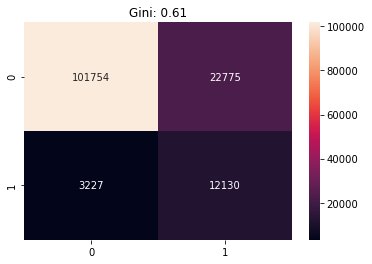

In [68]:
model = LogisticRegression(class_weight='balanced')
model = model.fit(TRAIN.values, data['loan_status'].values)

# transform test set
y_test = TEST['loan_status'].values
TEST = transform(TEST)

y_pred = model.predict(TEST)

print(classification_report(y_test, y_pred))

gini = 2*roc_auc_score(y_test, y_pred) - 1
plt.title(f'Gini: {gini:.2f}')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

## Coefficient scaling

In [69]:
WoE = [0.708396, -0.147986, -0.757155, -0.237045, -0.002945, 0.300903, 0.213164, 0.098333, -0.076295, -0.196744,
      0.200440, -0.062687, -0.337605, 0.235823, 0.062544, -0.055850, -0.203325, -0.619863, 1.283692, -0.850290,
      0.019978, 0.482927, 1.180022, -0.422353, 0.637729, 0.132203, -0.294894, 1.1143, 0.364, -0.05525, -0.395, -0.6785,
      -0.9522, -1.144166, 0.166972, 0.054438, -0.173420, 0.262772, -0.040475, 0.11994, -0.24381, 0.14378, 0.010764, -0.162,
      -0.10833, 0.229417]
beta = model.coef_[0, :]
# min-max scaling coefficients of logistic regression to root out negative values
beta = [(x-min(beta))/max(beta) for x in beta]
alpha = model.intercept_[0]
PDO = 10 # points to double the odds
factor = PDO / math.log(2)
base_score = 500
target_odds = 1
offset = base_score - (factor * math.log(target_odds))
n = len(beta)

# Score_i= (βi × WoE_i + α/n) × Factor + Offset/n
scores = {}
for i, feature in enumerate(TRAIN.columns):
    scores[feature] = round((beta[i] * WoE[i] + alpha/n)*factor + offset/n, 2)
scores

{'int_rate:(5.399, 12.3]': 18.42,
 'int_rate:(12.3, 19.18]': 8.59,
 'int_rate:(19.18, 26.06]': -4.04,
 'annual_inc:(1895.999, 50000.0]': 8.13,
 'annual_inc:(50000.0, 78000.0]': 10.79,
 'annual_inc:(78000.0, 7500000.0]': 16.48,
 'dti:(-0.001, 11.36]': 13.55,
 'dti:(11.36, 16.87]': 12.29,
 'dti:(16.87, 22.78]': 9.58,
 'dti:(22.78, 39.99]': 7.48,
 'inq_last_6mths:(-0.002, 0.667]': 13.83,
 'inq_last_6mths:(0.667, 1.333]': 9.89,
 'inq_last_6mths:(1.333, 2.0]': 5.62,
 'revol_util:(-0.001, 39.2]': 14.18,
 'revol_util:(39.2, 57.6]': 11.79,
 'revol_util:(57.6, 74.7]': 9.94,
 'revol_util:(74.7, 892.3]': 7.68,
 'out_prncp:(-0.001, 441.47]': -7.75,
 'out_prncp:(441.47, 32160.38]': 10.84,
 'total_pymnt:(-0.001, 5552.125]': -12.78,
 'total_pymnt:(5552.125, 9419.251]': 11.22,
 'total_pymnt:(9419.251, 15308.158]': 17.29,
 'total_pymnt:(15308.158, 57777.58]': 11.72,
 'last_pymnt_amnt:(-0.001, 545.96]': 1.29,
 'last_pymnt_amnt:(545.96, 36234.44]': 15.54,
 'term: 36 months': 12.54,
 'term: 60 months': 5.

## Cutoff analysis

In [70]:
output = pd.DataFrame()
output['total_score'] = np.sum(scores.values() * TRAIN, axis=1)
output['label'] = data['loan_status'].values
print(output['total_score'].describe())
output

count    326399.000000
mean        136.157682
std          25.042877
min          30.290000
25%         119.640000
50%         137.760000
75%         154.400000
max         204.090000
Name: total_score, dtype: float64


total_score  label
0            124.11      0
1             83.78      1
2             99.34      0
3            120.89      0
4            117.37      0
...             ...    ...
326394       159.45      1
326395       142.23      0
326396        64.45      1
326397       120.98      0
326398       115.21      0

[326399 rows x 2 columns]

In [71]:
@interact(threshold=(30, 200, 5))
def validation(threshold=120):
    output['predicted'] = output['total_score'].apply(lambda x: 1 if x < threshold else 0)
    print('\n', classification_report(output['label'], output['predicted']))
    gini = 2*roc_auc_score(output['label'], output['predicted']) - 1
    plt.title(f'Cutoff: {threshold}, Gini:{gini:.2f}')
    sns.heatmap(confusion_matrix(output['label'], output['predicted']), annot=True, fmt='d')
    plt.show()

interactive(children=(IntSlider(value=120, description='threshold', max=200, min=30, step=5), Output()), _dom_…

-------------------------------------------------------------------

## Neural network based scorecard

Epoch 1/2
10200/10200 [==============================] - 8s 771us/step - loss: 0.2462 - accuracy: 0.9159
Epoch 2/2
10200/10200 [==============================] - 8s 767us/step - loss: 0.2240 - accuracy: 0.9281
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    124529
           1       0.79      0.46      0.58     15357

    accuracy                           0.93    139886
   macro avg       0.87      0.72      0.77    139886
weighted avg       0.92      0.93      0.92    139886



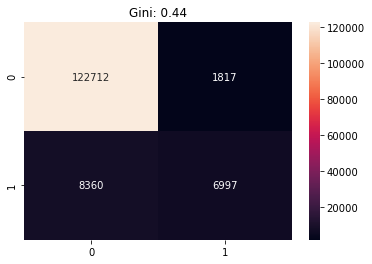

In [72]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

IN = Input(shape=(46, ))
OUT = Dense(1, activation='sigmoid')(IN)

model = Model(IN, OUT)
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(TRAIN.values, data['loan_status'].values, epochs=2)

y_pred = [1 if x >= 0.5 else 0 for x in model.predict(TEST)]

print(classification_report(y_test, y_pred))

gini = 2*roc_auc_score(y_test, y_pred) - 1
plt.title(f'Gini: {gini:.2f}')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

In [73]:
# obtain weights and biases of the neural network
W, b = model.layers[1].get_weights()
beta = W[:, 0]
alpha = b[0]
# min-max scaling coefficients
beta = [(x-min(beta))/max(beta) for x in beta]
PDO = 10 # points to double the odds
factor = PDO / math.log(2)
base_score = 500
target_odds = 1
offset = base_score - (factor * math.log(target_odds))
n = len(beta)

# Score_i= (βi × WoE_i + α/n) × Factor + Offset/n
scores = {}
for i, feature in enumerate(TRAIN.columns):
    scores[feature] = round((beta[i] * WoE[i])*factor + offset/n, 2)
scores

{'int_rate:(5.399, 12.3]': 22.34,
 'int_rate:(12.3, 19.18]': 7.85,
 'int_rate:(19.18, 26.06]': -8.63,
 'annual_inc:(1895.999, 50000.0]': 7.64,
 'annual_inc:(50000.0, 78000.0]': 10.82,
 'annual_inc:(78000.0, 7500000.0]': 17.04,
 'dti:(-0.001, 11.36]': 14.6,
 'dti:(11.36, 16.87]': 12.8,
 'dti:(16.87, 22.78]': 9.31,
 'dti:(22.78, 39.99]': 6.57,
 'inq_last_6mths:(-0.002, 0.667]': 14.78,
 'inq_last_6mths:(0.667, 1.333]': 9.61,
 'inq_last_6mths:(1.333, 2.0]': 4.22,
 'revol_util:(-0.001, 39.2]': 14.82,
 'revol_util:(39.2, 57.6]': 12.02,
 'revol_util:(57.6, 74.7]': 9.79,
 'revol_util:(74.7, 892.3]': 7.24,
 'out_prncp:(-0.001, 441.47]': -11.0,
 'out_prncp:(441.47, 32160.38]': 10.87,
 'total_pymnt:(-0.001, 5552.125]': -16.47,
 'total_pymnt:(5552.125, 9419.251]': 11.33,
 'total_pymnt:(9419.251, 15308.158]': 18.25,
 'total_pymnt:(15308.158, 57777.58]': 13.63,
 'last_pymnt_amnt:(-0.001, 545.96]': -0.47,
 'last_pymnt_amnt:(545.96, 36234.44]': 16.64,
 'term: 36 months': 13.21,
 'term: 60 months': 3.4